In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error, make_scorer
from sklearn.model_selection import cross_val_score, train_test_split
from xgboost import XGBRegressor

RANDOM_SEED = 101
 
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [4]:
train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')
# submission = pd.read_csv('SampleSubmission.csv')
# submission.head()

In [5]:
# submission.Item_Identifier = test.Item_Identifier
# submission.Outlet_Identifier = test.Outlet_Identifier

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5681 entries, 0 to 5680
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            5681 non-null   object 
 1   Item_Weight                4705 non-null   float64
 2   Item_Fat_Content           5681 non-null   object 
 3   Item_Visibility            5681 non-null   float64
 4   Item_Type                  5681 non-null   object 
 5   Item_MRP                   5681 non-null   float64
 6   Outlet_Identifier          5681 non-null   object 
 7   Outlet_Establishment_Year  5681 non-null   int64  
 8   Outlet_Size                4075 non-null   object 
 9   Outlet_Location_Type       5681 non-null   object 
 10  Outlet_Type                5681 non-null   object 
dtypes: float64(3), int64(1), object(7)
memory usage: 488.3+ KB


In [8]:
train.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,7060.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.643456,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.773750,0.026989,93.826500,1987.000000,834.247400
50%,12.600000,0.053931,143.012800,1999.000000,1794.331000
75%,16.850000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


In [9]:
train.isnull().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [10]:
test.isnull().sum()

Item_Identifier                 0
Item_Weight                   976
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  1606
Outlet_Location_Type            0
Outlet_Type                     0
dtype: int64

In [11]:
num_cols = ['Item_Weight','Item_Visibility','Item_MRP',]
cat_cols = ['Item_Type','Item_Fat_Content','Outlet_Identifier','Outlet_Size','Outlet_Location_Type','Outlet_Type','Outlet_Establishment_Year']
target = 'Item_Outlet_Sales'

In [12]:
train.Item_Fat_Content.replace({'Low Fat':'LF','reg':'Regular','low fat':'LF'}, inplace = True)

In [13]:
train.Item_Fat_Content.value_counts()

LF         5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

In [14]:
test.Item_Fat_Content.value_counts()

Low Fat    3396
Regular    1935
LF          206
reg          78
low fat      66
Name: Item_Fat_Content, dtype: int64

In [15]:
test.Item_Fat_Content.replace({'Low Fat':'LF','reg':'Regular','low fat':'LF'}, inplace = True)

In [16]:
train.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,LF,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,LF,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,LF,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


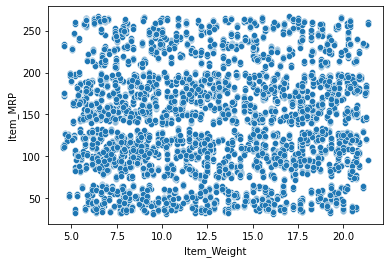

In [17]:
sns.scatterplot(x = 'Item_Weight',
               y = 'Item_MRP',
               data = train)

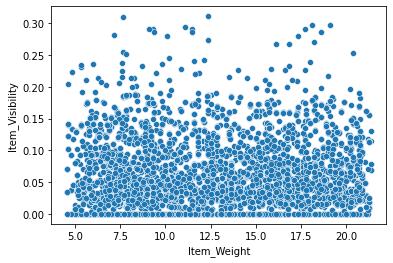

In [18]:
sns.scatterplot(x = 'Item_Weight',
               y = 'Item_Visibility',
               data = train)

In [19]:
weights = {}
for key,df in train.groupby(['Item_Type','Item_Fat_Content']):
    
    weights[key] = df['Item_Weight'].mean()
    
print(weights)

{('Baking Goods', 'LF'): 12.552996183206107, ('Baking Goods', 'Regular'): 12.013302919708034, ('Breads', 'LF'): 12.429911504424775, ('Breads', 'Regular'): 10.002142857142857, ('Breakfast', 'LF'): 11.849411764705886, ('Breakfast', 'Regular'): 13.336181818181823, ('Canned', 'LF'): 11.864650349650342, ('Canned', 'Regular'): 12.804288537549407, ('Dairy', 'LF'): 13.391497175141243, ('Dairy', 'Regular'): 13.483797169811307, ('Frozen Foods', 'LF'): 12.580333333333328, ('Frozen Foods', 'Regular'): 13.180539358600576, ('Fruits and Vegetables', 'LF'): 12.757046332046352, ('Fruits and Vegetables', 'Regular'): 13.708363273453134, ('Hard Drinks', 'LF'): 11.400327868852452, ('Health and Hygiene', 'LF'): 13.142313953488392, ('Household', 'LF'): 13.384736495388726, ('Meat', 'LF'): 13.565643939393933, ('Meat', 'Regular'): 12.335512195121952, ('Others', 'LF'): 13.853284671532842, ('Seafood', 'LF'): 13.805344827586207, ('Seafood', 'Regular'): 10.901818181818182, ('Snack Foods', 'LF'): 13.707176991150467,

In [20]:
train['Item_Weight'] = train.apply(lambda x:weights[(x['Item_Type'],x['Item_Fat_Content'])] if np.isnan(x['Item_Weight']) else x['Item_Weight'] ,axis = 1)

In [21]:
weights_test = {}
for key,df in test.groupby(['Item_Type','Item_Fat_Content']):
    weights_test[key] = df['Item_Weight'].mean()
print(weights_test)

{('Baking Goods', 'LF'): 12.620896739130426, ('Baking Goods', 'Regular'): 11.916194444444445, ('Breads', 'LF'): 11.472681159420297, ('Breads', 'Regular'): 10.269571428571432, ('Breakfast', 'LF'): 13.010749999999998, ('Breakfast', 'Regular'): 14.107906976744188, ('Canned', 'LF'): 12.037529761904759, ('Canned', 'Regular'): 12.706727748691097, ('Dairy', 'LF'): 13.361284403669716, ('Dairy', 'Regular'): 12.39095541401273, ('Frozen Foods', 'LF'): 11.660982532751083, ('Frozen Foods', 'Regular'): 12.544035087719282, ('Fruits and Vegetables', 'LF'): 12.66659268929504, ('Fruits and Vegetables', 'Regular'): 13.840490566037719, ('Hard Drinks', 'LF'): 11.844416666666666, ('Health and Hygiene', 'LF'): 13.216928571428557, ('Household', 'LF'): 13.270503802281391, ('Meat', 'LF'): 13.345891089108909, ('Meat', 'Regular'): 12.317426035502951, ('Others', 'LF'): 14.009725274725271, ('Seafood', 'LF'): 11.967666666666668, ('Seafood', 'Regular'): 15.97, ('Snack Foods', 'LF'): 13.782723684210533, ('Snack Foods'

In [22]:
test['Item_Weight'] = test.apply(lambda x:weights[(x['Item_Type'],x['Item_Fat_Content'])] if np.isnan(x['Item_Weight']) else x['Item_Weight'] ,axis = 1)

In [23]:
train['Outlet_Size'] = train['Outlet_Size'].fillna(train['Outlet_Size'].mode().values[0])
test['Outlet_Size'] = test['Outlet_Size'].fillna(train['Outlet_Size'].mode().values[0])

In [24]:
train.isnull().sum()

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64

In [25]:
test.isnull().sum()

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
dtype: int64

In [26]:
def cat_cols_info(df,col):
    print("Unique categories in {}".format(col))
    print(df[col].unique())
    print("Distribution of categories: \n")
    print(df[col].value_counts())
    print('Total number of categories: \n')
    print(df[col].nunique())
    print('\n')

In [27]:
for col in cat_cols:
    cat_cols_info(train,col)

Unique categories in Item_Type
['Dairy' 'Soft Drinks' 'Meat' 'Fruits and Vegetables' 'Household'
 'Baking Goods' 'Snack Foods' 'Frozen Foods' 'Breakfast'
 'Health and Hygiene' 'Hard Drinks' 'Canned' 'Breads' 'Starchy Foods'
 'Others' 'Seafood']
Distribution of categories: 

Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: Item_Type, dtype: int64
Total number of categories: 

16


Unique categories in Item_Fat_Content
['LF' 'Regular']
Distribution of categories: 

LF         5517
Regular    3006
Name: Item_Fat_Content, dtype: int64
Total number of categories

In [28]:
for col in cat_cols:
    cat_cols_info(test,col)

Unique categories in Item_Type
['Snack Foods' 'Dairy' 'Others' 'Fruits and Vegetables' 'Baking Goods'
 'Health and Hygiene' 'Breads' 'Hard Drinks' 'Seafood' 'Soft Drinks'
 'Household' 'Frozen Foods' 'Meat' 'Canned' 'Starchy Foods' 'Breakfast']
Distribution of categories: 

Snack Foods              789
Fruits and Vegetables    781
Household                638
Frozen Foods             570
Dairy                    454
Baking Goods             438
Canned                   435
Health and Hygiene       338
Meat                     311
Soft Drinks              281
Breads                   165
Hard Drinks              148
Starchy Foods            121
Others                   111
Breakfast                 76
Seafood                   25
Name: Item_Type, dtype: int64
Total number of categories: 

16


Unique categories in Item_Fat_Content
['LF' 'Regular']
Distribution of categories: 

LF         3668
Regular    2013
Name: Item_Fat_Content, dtype: int64
Total number of categories: 

2


Unique ca

## Data Visualization

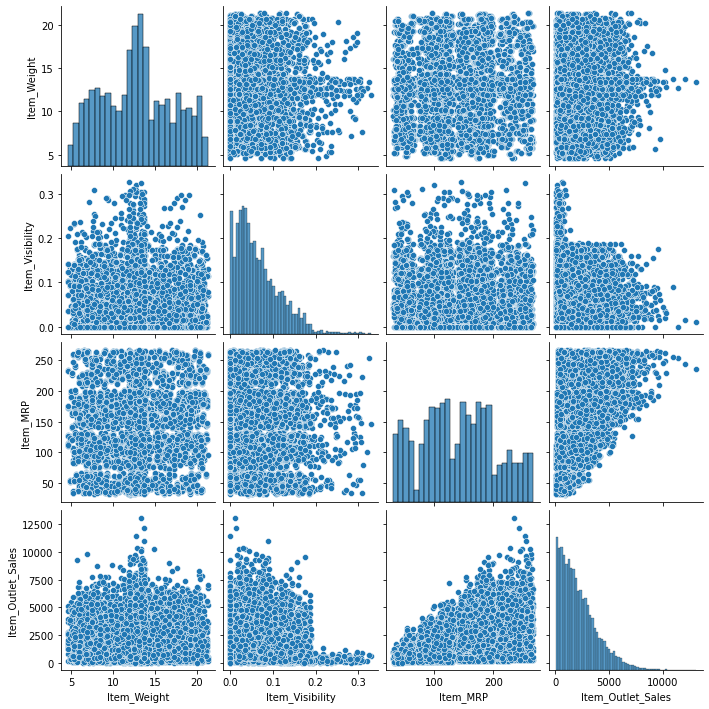

In [29]:
# numeric vs numeric
sns.pairplot(train[num_cols + [target]])

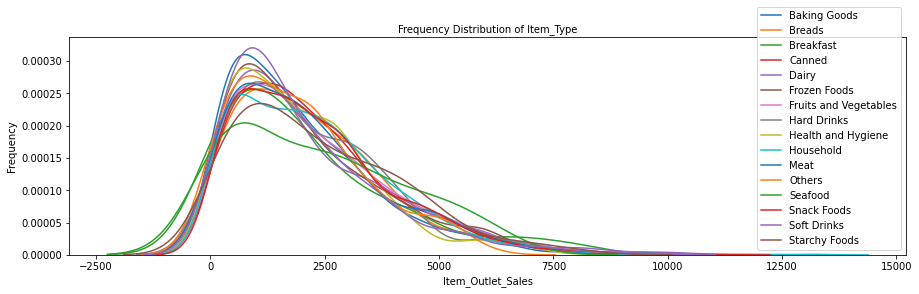

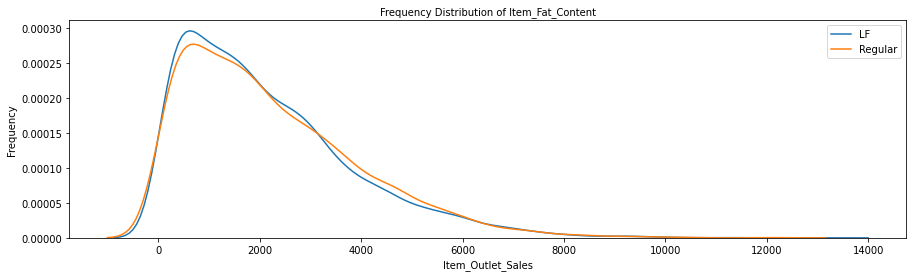

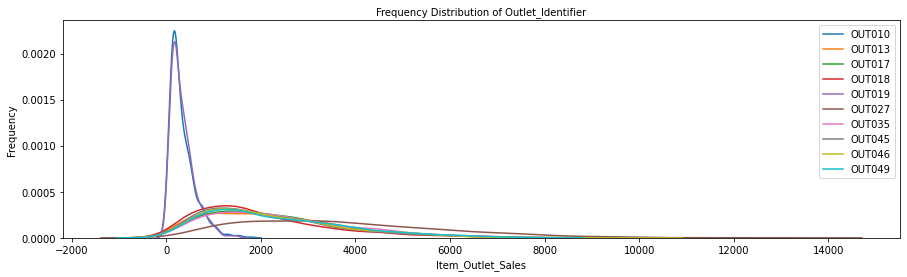

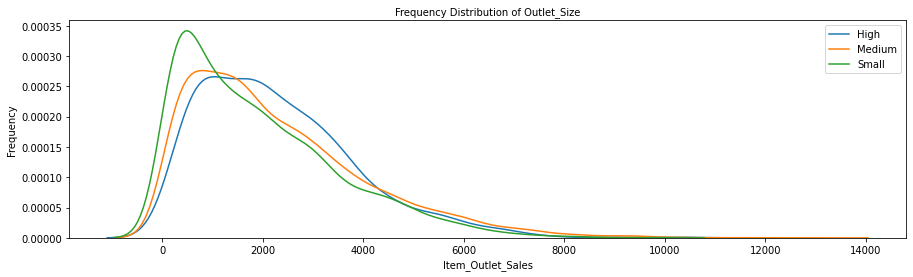

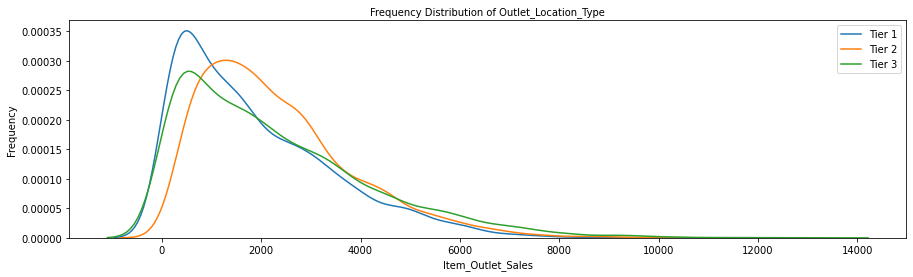

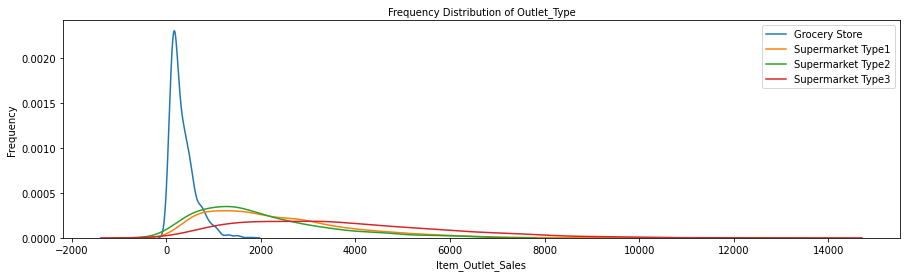

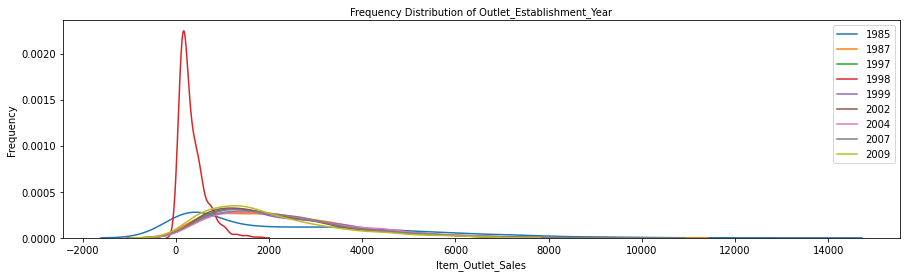

In [30]:
for col in cat_cols:
    fig = plt.figure(figsize = (15,4))
    ax = fig.add_subplot(111)
    j = 0
    for key, df in train.groupby([col]):
        ax = sns.kdeplot(df[target], label=key)
        ax.set_xlabel(target)
        ax.set_ylabel("Frequency")
        ax.legend(loc="best")
        ax.set_title('Frequency Distribution of {}'.format(col), fontsize = 10)
        j = j + 1

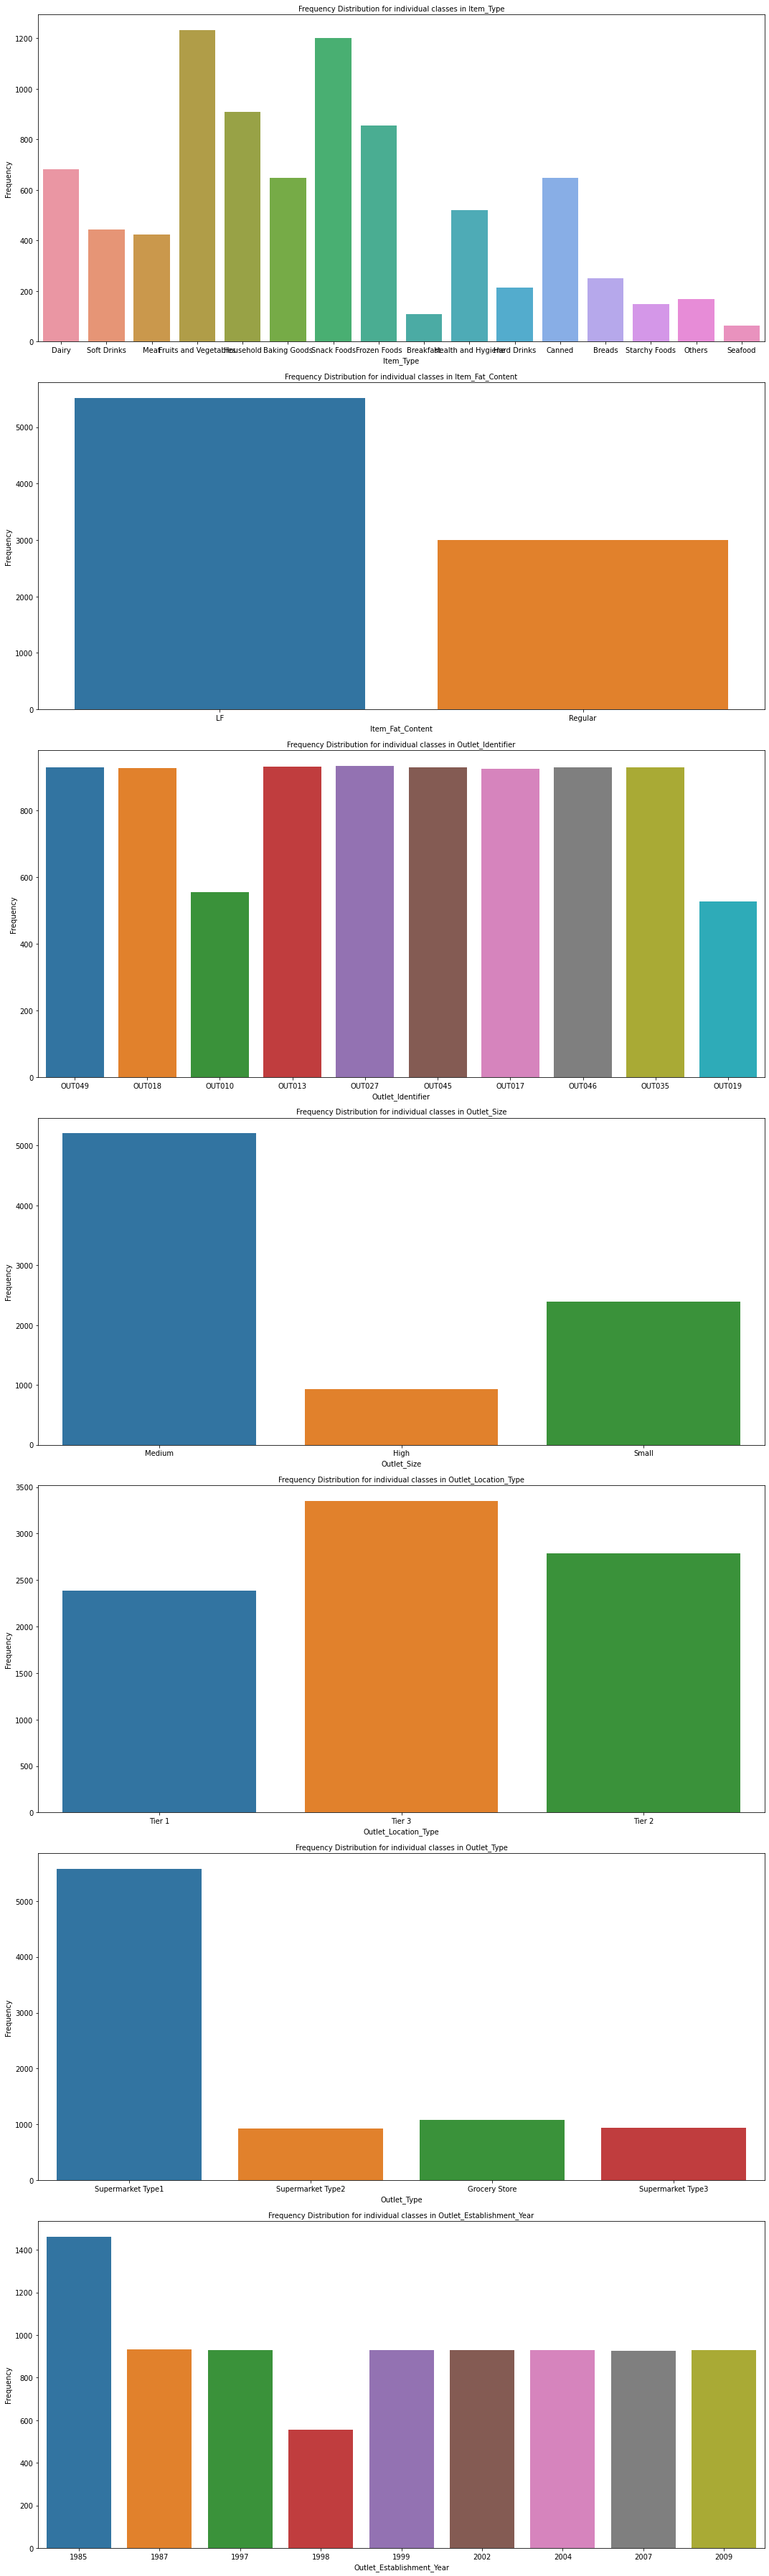

In [31]:
fig = plt.figure(figsize = (15,50))
j = 1
for cat_col in cat_cols:
    ax = fig.add_subplot(len(cat_cols),1,j)
    sns.countplot(x = cat_col,
                  data = train,
                  ax = ax)
    ax.set_xlabel(cat_col)
    ax.set_ylabel("Frequency")
    ax.set_title('Frequency Distribution for individual classes in {}'.format(cat_col), fontsize = 10)
    j = j + 1
    
plt.tight_layout()

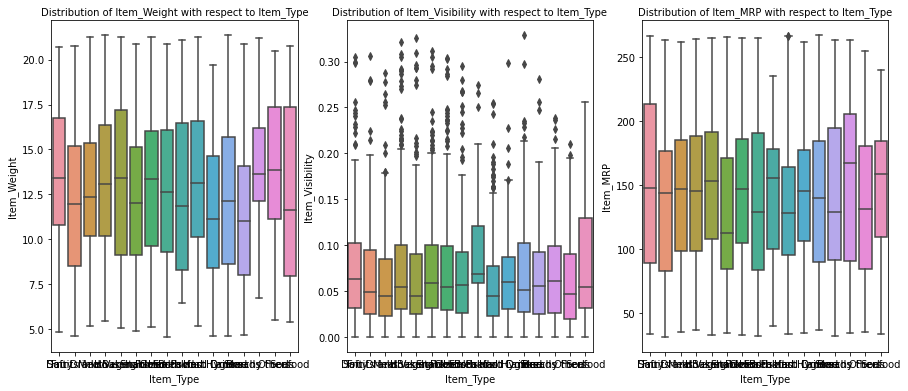

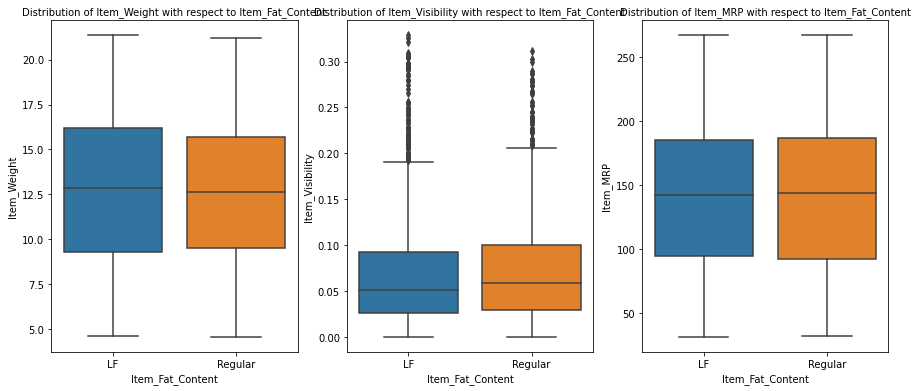

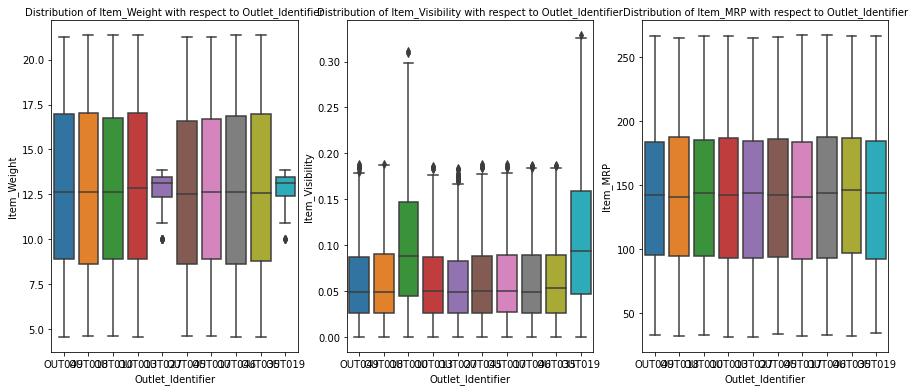

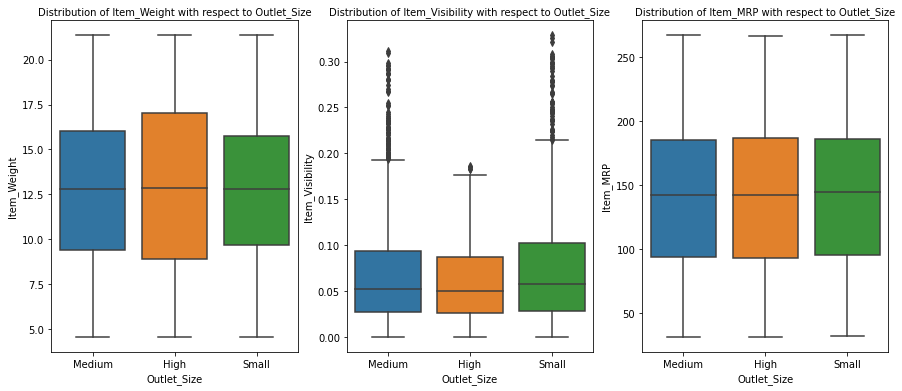

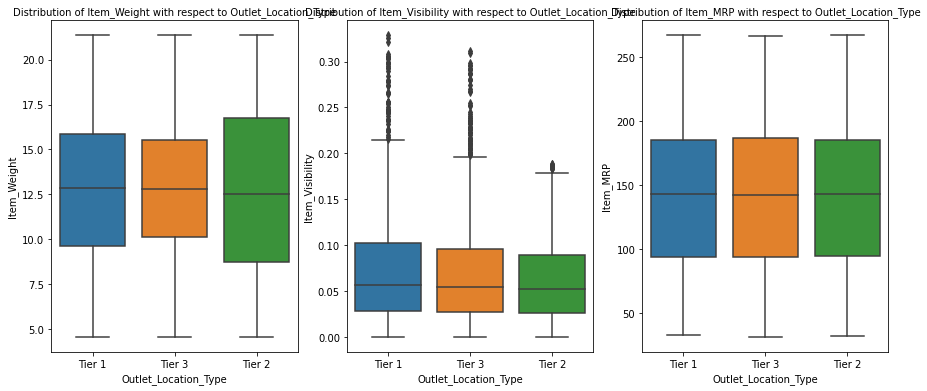

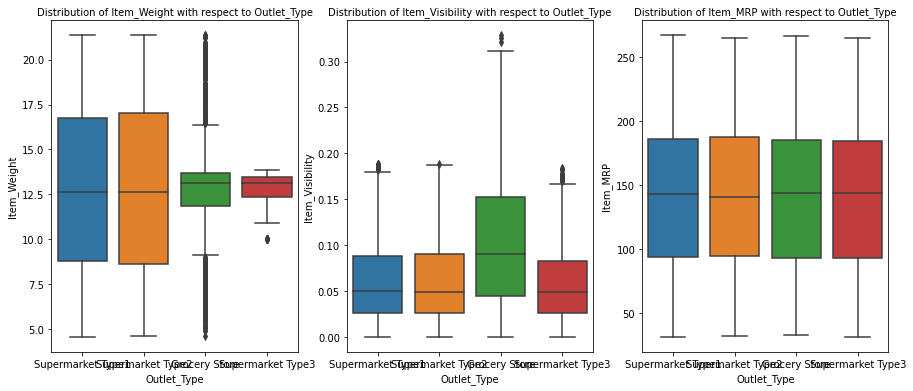

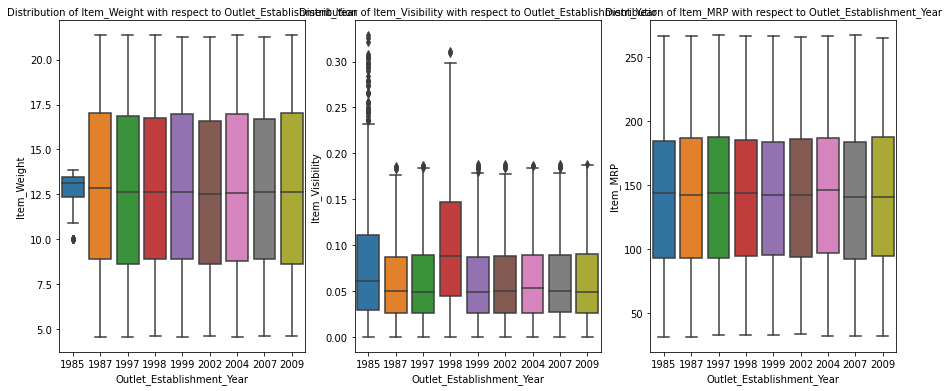

In [32]:
for cat_col in cat_cols:
    fig = plt.figure(figsize = (15,50))
    j = 1
    for num_col in num_cols:
        ax = fig.add_subplot(len(cat_cols),len(num_cols),j)
        sns.boxplot(y = num_col,
                    x = cat_col, 
                    data = train, 
                    ax = ax)
        ax.set_xlabel(cat_col)
        ax.set_ylabel(num_col)
        ax.set_title('Distribution of {} with respect to {}'.format(num_col,cat_col), fontsize = 10)
        j = j + 1

In [33]:
train_corr = train[num_cols].corr()

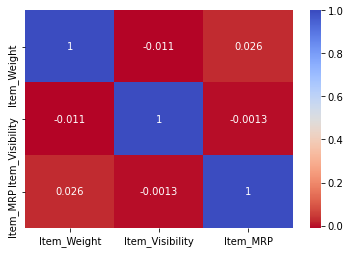

In [34]:
sns.heatmap(train_corr, annot= True, cmap='coolwarm_r')
plt.show()

In [35]:
def handle_outliers(df,var,target,tol):
    var_data = df[var].sort_values().values
    q25, q75 = np.percentile(var_data, 25), np.percentile(var_data, 75)
    
    print('Outliers handling for {}'.format(var))
    print('Quartile 25: {} | Quartile 75: {}'.format(q25, q75))
    iqr = q75 - q25
    print('IQR {}'.format(iqr))
    
    cut_off = iqr * tol
    lower, upper = q25 - cut_off, q75 + cut_off
    print('Cut Off: {}'.format(cut_off))
    print('{} Lower: {}'.format(var,lower))
    print('{} Upper: {}'.format(var,upper))
    
    outliers = [x for x in var_data if x < lower or x > upper]

    print('Number of Outliers in feature {}: {}'.format(var,len(outliers)))

    print('{} outliers:{}'.format(var,outliers))

    print('----' * 25)
    print('\n')
    print('\n')
        
    return list(df[(df[var] > upper) | (df[var] < lower)].index)

In [36]:
outliers = []
for num_col in num_cols:
    outliers.extend(handle_outliers(train,num_col,target,1.5))
outliers = list(set(outliers))
print(len(outliers))

Outliers handling for Item_Weight
Quartile 25: 9.31 | Quartile 75: 16.0
IQR 6.6899999999999995
Cut Off: 10.035
Item_Weight Lower: -0.7249999999999996
Item_Weight Upper: 26.035
Number of Outliers in feature Item_Weight: 0
Item_Weight outliers:[]
----------------------------------------------------------------------------------------------------




Outliers handling for Item_Visibility
Quartile 25: 0.026989477499999998 | Quartile 75: 0.0945852925
IQR 0.067595815
Cut Off: 0.1013937225
Item_Visibility Lower: -0.07440424500000001
Item_Visibility Upper: 0.195979015
Number of Outliers in feature Item_Visibility: 144
Item_Visibility outliers:[0.196438668, 0.196490902, 0.196659953, 0.19780911, 0.19831664899999998, 0.19842484100000002, 0.19875618, 0.19899855, 0.199935881, 0.199955274, 0.20042639999999998, 0.20168772, 0.203510667, 0.2047, 0.20471303600000001, 0.204984538, 0.20529482699999999, 0.205484395, 0.205605116, 0.20778348300000002, 0.20816215600000001, 0.208397715, 0.208662546, 0.20898712

In [37]:
train = train.drop(outliers)

In [38]:
train.shape, test.shape

((8379, 12), (5681, 11))

In [39]:
train = train[num_cols + cat_cols + [target]]
test = test[num_cols + cat_cols] 

In [40]:
train = pd.get_dummies(train,columns=cat_cols,drop_first=True)

In [41]:
train.head()

,Item_Weight,Item_Visibility,Item_MRP,Item_Outlet_Sales,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen Foods,Item_Type_Fruits and Vegetables,Item_Type_Hard Drinks,Item_Type_Health and Hygiene,Item_Type_Household,Item_Type_Meat,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack Foods,Item_Type_Soft Drinks,Item_Type_Starchy Foods,Item_Fat_Content_Regular,Outlet_Identifier_OUT013,Outlet_Identifier_OUT017,Outlet_Identifier_OUT018,Outlet_Identifier_OUT019,Outlet_Identifier_OUT027,Outlet_Identifier_OUT035,Outlet_Identifier_OUT045,Outlet_Identifier_OUT046,Outlet_Identifier_OUT049,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3,Outlet_Establishment_Year_1987,Outlet_Establishment_Year_1997,Outlet_Establishment_Year_1998,Outlet_Establishment_Year_1999,Outlet_Establishment_Year_2002,Outlet_Establishment_Year_2004,Outlet_Establishment_Year_2007,Outlet_Establishment_Year_2009
0,9.30,0.016047,249.8092,3735.1380,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0
1,5.92,0.019278,48.2692,443.4228,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1
2,17.50,0.016760,141.6180,2097.2700,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0
3,19.20,0.000000,182.0950,732.3800,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0
4,8.93,0.000000,53.8614,994.7052,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0


In [42]:
test = pd.get_dummies(test,columns=cat_cols,drop_first=True)

In [43]:
test.shape

(5681, 43)

In [44]:
train_data, test_data = train_test_split(train, test_size = .2, random_state = RANDOM_SEED)

In [45]:
train_data.head()

,Item_Weight,Item_Visibility,Item_MRP,Item_Outlet_Sales,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen Foods,Item_Type_Fruits and Vegetables,Item_Type_Hard Drinks,Item_Type_Health and Hygiene,Item_Type_Household,Item_Type_Meat,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack Foods,Item_Type_Soft Drinks,Item_Type_Starchy Foods,Item_Fat_Content_Regular,Outlet_Identifier_OUT013,Outlet_Identifier_OUT017,Outlet_Identifier_OUT018,Outlet_Identifier_OUT019,Outlet_Identifier_OUT027,Outlet_Identifier_OUT035,Outlet_Identifier_OUT045,Outlet_Identifier_OUT046,Outlet_Identifier_OUT049,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3,Outlet_Establishment_Year_1987,Outlet_Establishment_Year_1997,Outlet_Establishment_Year_1998,Outlet_Establishment_Year_1999,Outlet_Establishment_Year_2002,Outlet_Establishment_Year_2004,Outlet_Establishment_Year_2007,Outlet_Establishment_Year_2009
8436,12.850000,0.121725,45.1428,527.3136,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0
6302,15.600000,0.081268,110.2544,1789.6704,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,1,0,0,0,0,0,0,1,0,0,0
2657,8.785000,0.020609,155.1656,4016.1056,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0
2961,11.963444,0.114610,197.0084,3372.9428,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0
1437,6.850000,0.022864,260.0594,6018.1662,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0


In [46]:
X_train = train_data.drop('Item_Outlet_Sales', axis = 1)
X_test = test_data.drop('Item_Outlet_Sales', axis = 1)

y_train = train_data[target]
y_test = test_data[target]

In [47]:
X_train.shape, X_test.shape

((6703, 43), (1676, 43))

In [48]:
test.shape

(5681, 43)

In [49]:
sc = StandardScaler()
sc.fit(X_train[num_cols])
X_train[num_cols] = sc.transform(X_train[num_cols])

In [50]:
X_test[num_cols] = sc.transform(X_test[num_cols])
test[num_cols] = sc.transform(test[num_cols])

In [ ]:
reg_models = ['GradientBoostingRegressor',
             'RandomForestRegressor',
             'XGBRegressor']

In [ ]:
mse = []
rmse = []
mae = []
mdae = []
estimators = []
models = []

In [ ]:
reg_models

['GradientBoostingRegressor', 'RandomForestRegressor', 'XGBRegressor']

In [ ]:
for reg_model in reg_models:
    model = eval(reg_model)()
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    models.append(type(model).__name__)
    estimators.append((type(model).__name__,model))
    mse.append(mean_squared_error(y_test,y_pred))
    rmse.append(mean_squared_error(y_test,y_pred)**.5)
    mae.append(mean_absolute_error(y_test,y_pred))
    mdae.append(median_absolute_error(y_test,y_pred))

[13:05:58] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
model_dict = {"Models":models,
             "mse":mse,
             "rmse":rmse,
             "mae":mae,
             "mdae":mdae
             }

In [ ]:
model_df = pd.DataFrame(model_dict)
model_df

,Models,mse,rmse,mae,mdae
0,GradientBoostingRegressor,1.178151e+06,1085.426746,781.098978,545.120392
1,RandomForestRegressor,1.274264e+06,1128.833085,810.697430,563.989193
2,XGBRegressor,1.169502e+06,1081.435306,780.093037,548.781602


In [ ]:
xgb = XGBRegressor()
xgb.fit(X_train,y_train)
y_pred = xgb.predict(test)

[13:15:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
submission.head()

,Item_Identifier,Outlet_Identifier,Item_Outlet_Sales
0,FDW58,OUT049,0
1,FDW14,OUT017,0
2,NCN55,OUT010,0
3,FDQ58,OUT017,0
4,FDY38,OUT027,0


In [ ]:
submission.Item_Outlet_Sales = y_pred

In [ ]:

submission.head()

,Item_Identifier,Outlet_Identifier,Item_Outlet_Sales
0,FDW58,OUT049,1590.351074
1,FDW14,OUT017,1394.272583
2,NCN55,OUT010,675.022827
3,FDQ58,OUT017,2662.983887
4,FDY38,OUT027,6327.599121


In [ ]:
submission.to_csv('submission.csv',index=False)

In [ ]:
model_param_grid = {}

In [ ]:
model_param_grid['GradientBoostingRegressor'] = {'loss':['ls', 'lad', 'huber', 'quantile'],
                                                'n_estimators':[50,100,150,200],
                                              'learning_rate':[0.1,0.01,0.02],
                                              'max_features':['auto','sqrt','log2']}

In [ ]:
model_param_grid['RandomForestRegressor']= {'n_estimators':[50,100,150,200],
                                      'criterion':['mse','mae'],
                                      'max_features':['auto','sqrt','log2']}

In [ ]:
model_param_grid['XGBRegressor']={'n_estimators':[50,100,150,200],
                                 'learning_rate':[0.1,0.01,0.02],
                                 'booster':['gbtree', 'gblinear','dart'],
                                 }

In [ ]:
model_param_grid

{'GradientBoostingRegressor': {'loss': ['ls', 'lad', 'huber', 'quantile'],
  'n_estimators': [50, 100, 150, 200],
  'learning_rate': [0.1, 0.01, 0.02],
  'max_features': ['auto', 'sqrt', 'log2']},
 'RandomForestRegressor': {'n_estimators': [50, 100, 150, 200],
  'criterion': ['mse', 'mae'],
  'max_features': ['auto', 'sqrt', 'log2']},
 'XGBRegressor': {'n_estimators': [50, 100, 150, 200],
  'learning_rate': [0.1, 0.01, 0.02],
  'booster': ['gbtree', 'gblinear', 'dart']}}

In [ ]:
from sklearn.model_selection import GridSearchCV
def tune_parameters(model_name,model,params,cv,scorer,X,y):
    best_model = GridSearchCV(estimator = model,
                              param_grid = params,
                              scoring = scorer,
                              cv = cv,
                              n_jobs = -1).fit(X, y)
    print("Tuning Results for ", model_name)
    print("Best Score Achieved: ",best_model.best_score_)
    print("Best Parameters Used: ",best_model.best_params_)
    return best_model.best_estimator_

In [ ]:
from sklearn.metrics import make_scorer

# Define scorer
def rmse_scorer(y_test, y_pred):
    rmse_score = mean_squared_error(y_test, y_pred) ** .5
    return rmse_score

In [ ]:
rmse_score = make_scorer(rmse_scorer,greater_is_better=False)

In [ ]:
best_estimators = []

In [ ]:
for m_name, m_obj in estimators:
    best_estimators.append((m_name,tune_parameters(m_name,
                                                   m_obj,
                                                   model_param_grid[m_name],
                                                   5,
                                                   rmse_score,
                                                   X_train,
                                                   y_train)))

Tuning Results for  GradientBoostingRegressor
Best Score Achieved:  -1094.2884594737998
Best Parameters Used:  {'learning_rate': 0.1, 'loss': 'ls', 'max_features': 'auto', 'n_estimators': 50}
Tuning Results for  RandomForestRegressor
Best Score Achieved:  -1138.7648398968
Best Parameters Used:  {'criterion': 'mae', 'max_features': 'auto', 'n_estimators': 200}
[15:52:56] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Tuning Results for  XGBRegressor
Best Score Achieved:  -1093.08480860593
Best Parameters Used:  {'booster': 'gbtree', 'learning_rate': 0.1, 'n_estimators': 50}


In [ ]:
xgb_tuned = XGBRegressor(booster='gbtree', learning_rate= 0.1, n_estimators= 150)
xgb_tuned.fit(X_train,y_train)
y_pred = xgb_tuned.predict(test)

[16:04:29] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
submission.Item_Outlet_Sales = y_pred

In [ ]:
submission.shape

(5681, 3)

In [ ]:
submission.to_csv('submission.csv',index=False)

In [ ]:
gbr_tuned = GradientBoostingRegressor(n_estimators=150, loss='ls',learning_rate=0.1,max_features='auto')
gbr_tuned.fit(X_train,y_train)
y_pred = gbr_tuned.predict(test)

In [ ]:
submission.Item_Outlet_Sales = y_pred
submission.to_csv('submission.csv',index=False)

**Creating Artifical Neural Network using Tensorflow**

In [51]:
import tensorflow as tf

In [53]:
tf.random.set_seed(42)

model = tf.keras.models.Sequential([
              tf.keras.layers.Dense(100),
              tf.keras.layers.Dense(50, activation='relu'),
              tf.keras.layers.Dense(25, activation='relu'),
              tf.keras.layers.Dense(10, activation='relu'),
              tf.keras.layers.Dense(1),
])

model.compile(loss=tf.keras.losses.mae,
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['mae'])

model.fit(X_train,y_train, epochs=200)

Epoch 1/200
210/210 [==============================] - 1s 2ms/step - loss: 1982.3563 - mae: 1982.3563
Epoch 2/200
210/210 [==============================] - 0s 2ms/step - loss: 895.6656 - mae: 895.6656
Epoch 3/200
210/210 [==============================] - 0s 2ms/step - loss: 803.6604 - mae: 803.6604
Epoch 4/200
210/210 [==============================] - 0s 2ms/step - loss: 795.9094 - mae: 795.9094
Epoch 5/200
210/210 [==============================] - 0s 2ms/step - loss: 775.1320 - mae: 775.1320
Epoch 6/200
210/210 [==============================] - 0s 2ms/step - loss: 757.7779 - mae: 757.7779
Epoch 7/200
210/210 [==============================] - 0s 2ms/step - loss: 791.6975 - mae: 791.6975
Epoch 8/200
210/210 [==============================] - 0s 2ms/step - loss: 760.2993 - mae: 760.2993
Epoch 9/200
210/210 [==============================] - 0s 2ms/step - loss: 760.2785 - mae: 760.2785
Epoch 10/200
210/210 [==============================] - 0s 2ms/step - loss: 753.0907 - mae: 753.09